# Content based image retrieval using deep autoencoders

In the following we approach [content based image retrieval](https://en.wikipedia.org/wiki/Content-based_image_retrieval) by using short binary representations of the images learned via [Deep Autoencoders](https://en.wikipedia.org/wiki/Deep_belief_network). We basically replicate the approach as described in this paper by Hinton and Krizhevsky: http://www.cs.toronto.edu/~fritz/absps/esann-deep-final.pdf  



Here we use the Flickr25k dataset. Images have been resized to 32x32px (RGB => 3072 dimensions) before.

## 256bit codes of full image
A Deep Autoencoder (same architecture as described in the paper) has been trained to reconstruct the whole images as well as possible. 

The 256bit encodings (numpy-array of shape (25000, 256) ) for all images have been calculated 
and stored as hdf5-table.

Load the codes:

In [1]:
import h5py
import numpy as np

with h5py.File('../deep_learning_data/codes_sda_full.hdf5', 'r') as f:
    full_codes = f['X'][:]

Fixing one certain image as "query image", we can now search for images with similar codes. We do this by calculating the [Hamming Distance](https://en.wikipedia.org/wiki/Hamming_distance) to all other codes:

In [2]:
#get the id corresponding to a random query image
query_id = np.random.randint(25000)

#calculate hamming distances
distances = np.array([np.sum(full_codes[i] != full_codes[query_id]) for i in range(25000)])

Now we want to see which images have the closest 256-bit encodings to the query image. To that end we display a certain number of most similar images, the first image will always be the query image itself:

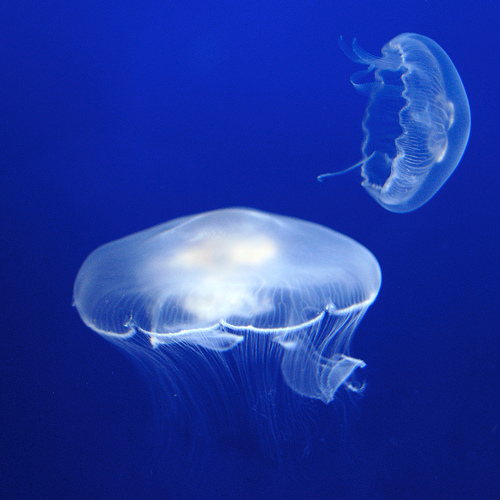

code distance:0 /256


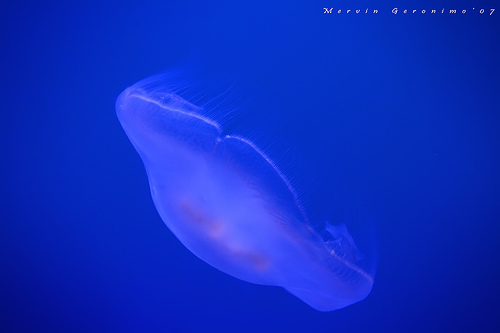

code distance:22 /256


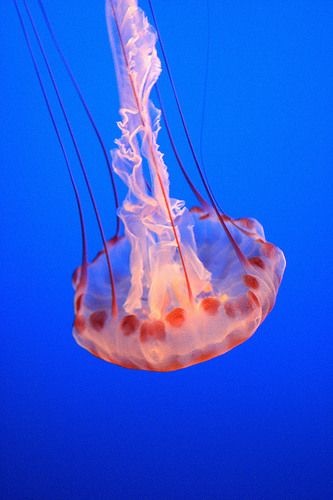

code distance:27 /256


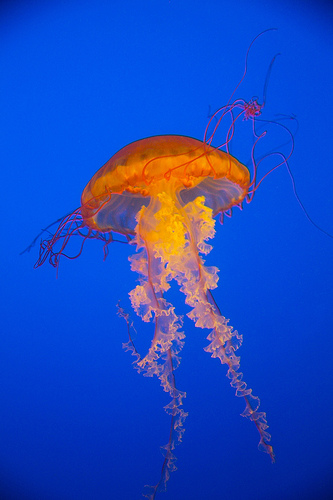

code distance:28 /256


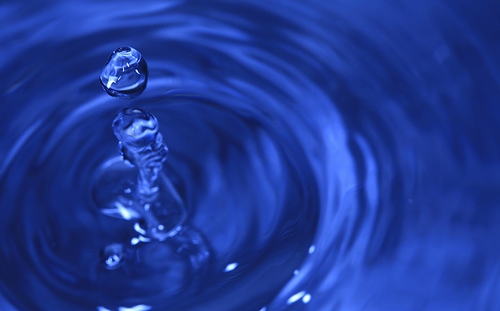

code distance:28 /256


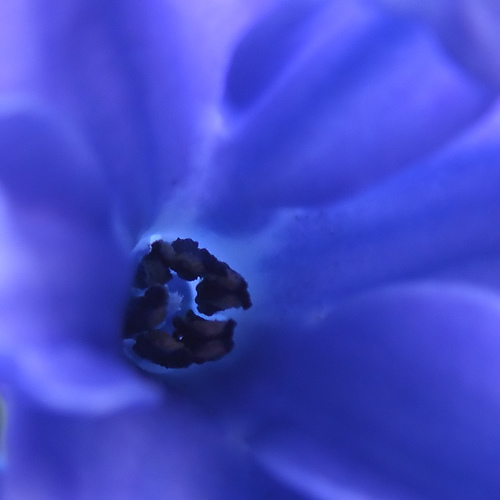

code distance:30 /256


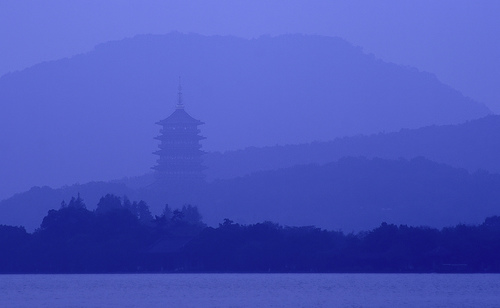

code distance:30 /256


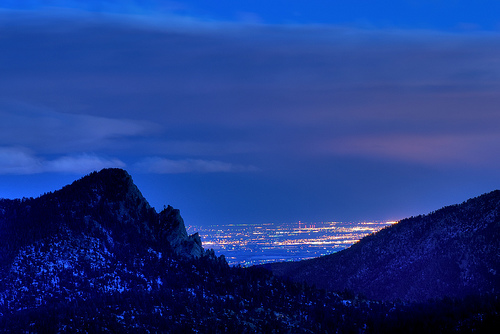

code distance:31 /256


In [11]:
from IPython.display import display, Image

#number of most similar images that will be displayed
display_num = 8

#load the image paths 
images = np.genfromtxt('./../flickr_index.txt', dtype = 'str')

#display the images (original size) which have the most similar code to the given image
for i in range(display_num ):
    display(Image(filename = ('./../../data/image_datasets/Flickr_orig/' + images[distances.argsort()[i]]), width=200) )
    print('code distance:{} /256'.format(distances[distances.argsort()[i]]))
    

## 28bit codes of variable resolution retina patches
Considering that we also want to find images which have similar spots, we further use the variable resolution retina approach as described in the above mentioned paper. To that end, 81 16x16px patches have been extracted from every 32x32px image (every position by shifting the grid in 2px steps). The outer 4px-'rings' are sampled only in half resolution. (thus the description 'variable resolution retina') . Considering 3 color chanels, each patch has 336 numerical dimensions. 

Another Deep Autoencoder (again same architecture as described in the paper) has been trained to reconstruct the patches as well as possible from 28bit encodings. The codes have been calculated and stored in a python dictionary which serves as hashing table. The dictionary keys are the 28bit codes as uint (i.e. numbers between $0$ and $2^{28}$), the values are lists with image ids of the images having patches with this code. The whole dictionary has been saved as python pickle file.

Load the hashing table :

In [14]:
import pickle

with open('../../local_data/varpatch_hashing_table_sda.pkl', 'rb') as f:
    varpatch_hashing_table = pickle.load(f)

We first define a function searching for similar patches given the 28bit representation of one patch. As proposed by Hinton / Krizhevsky we only consider patches with a hamming distance $d$ of no more than 3 and for each "query patch" an image only gets assigned a score $s$ once: 

$ s(d) = 2^{3-d}$

I.e. the maximal score an image can get for each query patch is 8 (if it has a patch with the same representation) and the lowest is 1 (if 

In [15]:
def get_scores(code_uint, hashing_table, verbose = 0, dataset_size = 25000):
    """
    search over all patches with a hamming distance of no more than 3 and return the maximal score for each image 
    containing corresponding patches:
    score = 2**(3-d) where d is the hamming distance of the code
    
    :param code_uint: the 28bit query code as uint
    :param hashing_table: dictionary with the 28bit-codes as key, lists containing image_ids as values
    :param verbose: int, 0 for no output, >0 for printing information during query
    :param dataset_size: size of the dataset, 25000 for FLickr25k
    
    :returns: array of shape (dataset_size,)
    """ 
    #initialize score array, position corresponds to the id of the respective image
    scores = np.zeros(dataset_size)
    
    #set type to avoid duplicates
    found_images = set()

    hashing_table
    #parse all codes with hamming distance 0, score  
    for id in (set(hashing_table.get(code_uint ,[]))):
        scores[id] += 2**3
        found_images.add(id)      

    #parse all code with hamming distance 1
    for i in range(28):
        #using the bitwise xor with 2**i will flip the i-th bit of the query-code
        hashing_code =  (code_uint ^ 2**i)
        for id in set(hashing_table.get(hashing_code,[])).difference(found_images):
            scores[id] += 2**2
            found_images.add(id)      

        #parse all codes with hamming distance 2
        for j in range(28):
            if j == i:
                continue
            hashing_code =  (code_uint ^ (2**i  + 2**j))
            for id in set(hashing_table.get(hashing_code,[])).difference(found_images):
                scores[id] += 2**1
                found_images.add(id) 
                
            #parse all codes with hamming distance 3
            for k in range(28):
                if k == i or k == j:
                    continue
                hashing_code =  (code_uint ^ (2**i  + 2**j + 2**k))
                for id in set(hashing_table.get(hashing_code,[])).difference(found_images):
                    scores[id] += 2**0
                    found_images.add(id)      
    if verbose > 0:
        print('found {},{},{},{} pictures with hamming distance 0,1,2,3 resp.'.format(
            np.sum(scores == 8), 
            np.sum(scores == 4), 
            np.sum(scores == 2), 
            np.sum(scores == 1), 
            ))
        
    return(scores)  

next we define a convenience function which iterates over all patches given the id of a query image cumulates the
scores for the images in the dataset.

We filled a hdf5 table with the 28bit codes for each image and each patch. 
Rows refer to image ids, columns to patch locations (right, then down). So table has the shape (25000, 81). 

Now given the id of our query image, we can iteratively search for similar codes for each of the 81 patches and finally see which images have most similar patches. 


In [17]:
import h5py

def query_varpatch_codes(image_id, 
                         hashing_table, 
                         code_table_path = '../../local_data/varpatch_codes_sda.hdf5', 
                         verbose = 0, 
                         dataset_size = 25000):
    """
    iterate over all varpatches of a given query image and cumulate the similarities of all the images in the dataset
    
    :param image_id: int refering to the query image
    :param hashing_table: dictionary with the 28bit-codes as key, lists containing image_ids as values
    :code_table_path: string with a path to the hdf5 table which holds the 28bit representations for all patches
    :param verbose: 0 for no output, 1 for some output, >1 for even more output
    :param dataset_size: size of the dataset, 25000 for FLickr25k
    
    :returns: array of shape (dataset_size,)
    """ 
    #initialize score array, poition corresponds to image id
    scores = np.zeros(dataset_size)

    #open the varpatch code table
    with h5py.File(code_table_path, 'r') as f:
        ds = f['X']
        
        #iterate over all patch positions
        for i in range(81):
            if verbose > 0:
                print('querying patch {} / 81'.format(i+1))
                
            #read the query code from the code table
            query_code = ds[image_id, i]
            
            #retrieve the similarity scores for each patch and cumulate them
            scores = scores + get_scores(query_code, hashing_table = hashing_table, verbose = verbose -1)       
            
    return scores

now we can perform the varpatch-query for the query image:

In [19]:
scores = query_varpatch_codes(query_id, varpatch_hashing_table, verbose = 0)

visualize the results:

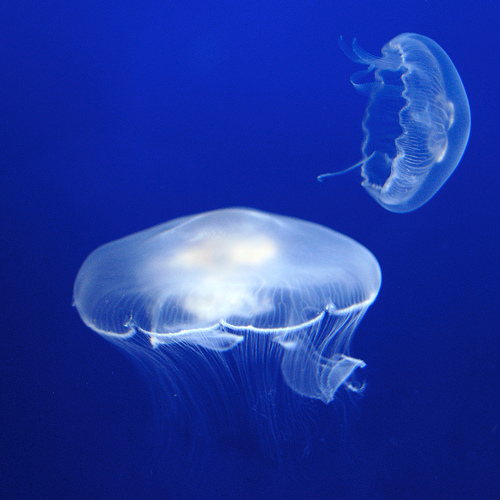

varpatch score: 648.0


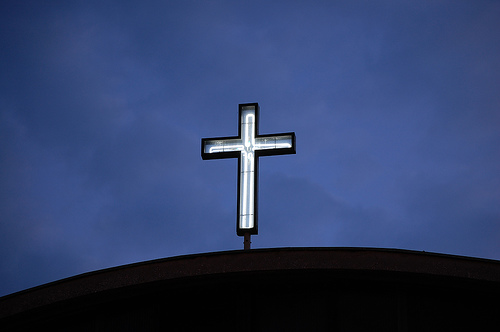

varpatch score: 74.0


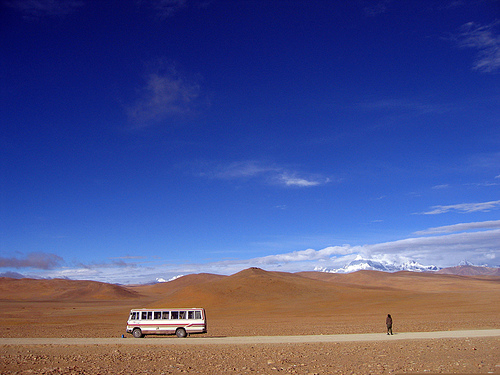

varpatch score: 72.0


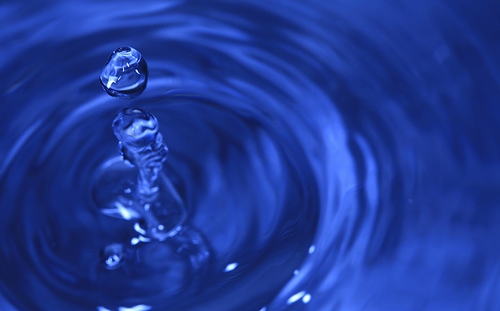

varpatch score: 67.0


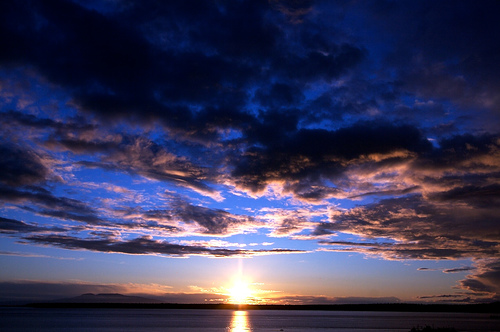

varpatch score: 64.0


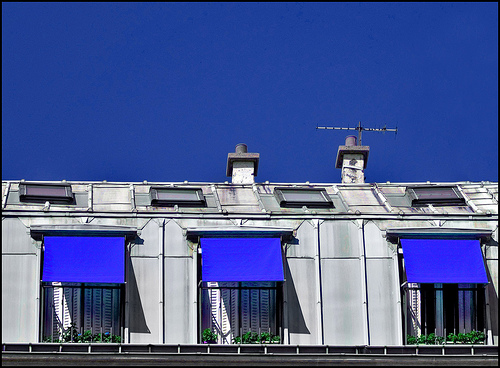

varpatch score: 64.0


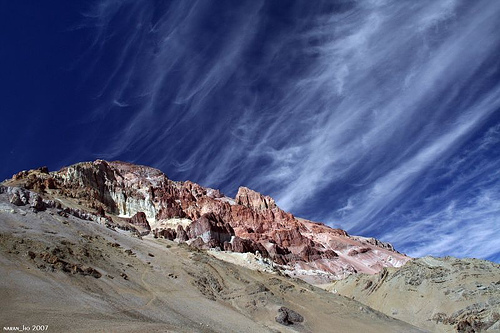

varpatch score: 60.0


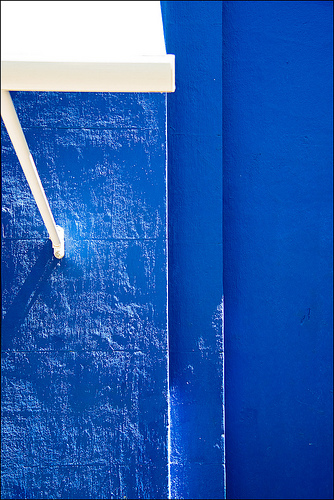

varpatch score: 59.0


In [22]:
#number of most similar images to display
display_num = 8

for i in range(display_num):
    display(Image(filename = ('../../data/image_datasets/Flickr_orig/' + images[scores.argsort()[::-1][i]]), width=200) )
    print('varpatch score: {}'.format(scores[scores.argsort()[::-1][i]]))
    

## Combined approach
Finally we can combine both approaches by combining the rankings. 


In [23]:
import scipy.stats

def get_similar_images(image_id, full_codes, varpatch_hashing_table, return_distances_scores = 0, verbose = 0):
    """
    combine the ranking retrieved by calculating similarities of 256bit codes representing the whole image and 
    the ranking retrieved by comparing all variable resolution patches of the given image to those of all other 
    images in the dataset
    
    :param image_id: int refering to the query image
    :param full_codes: np-array with the 256bit codes for each images (shape: (dataset_size, 256))
    :param varpatch_hashing_table: dictionary with the 28bit-codes as key, lists containing image_ids as values
    :param return_distances_scores: if 1, not only the ranking but also the 256bit code based distances and the 
        varpatch scores will be returned
    :param verbose: 0 for no output, 1 for some output, >1 for even more output
    
    :returns: array of shape (dataset_size,)
    """ 
    if verbose > 0:
        print('performing full code distance based query')
    #get similarities from full codes
    full_code_distances = np.array([np.sum(full_codes[i] != full_codes[image_id]) for i in range(25000)])
    #get the ranks, lowest to highest distance
    full_code_ranking = scipy.stats.rankdata(full_code_distances)
    
    if verbose > 0:
        print('performing varpatch score based query')
    #get similarities from patches
    varpatch_scores = query_varpatch_codes(image_id, varpatch_hashing_table, verbose = verbose - 1)
    #get the ranks, highest to lowest score
    varpatch_code_ranking = len(varpatch_scores) - scipy.stats.rankdata(varpatch_scores)
    
    #add the ranks:
    ranking = varpatch_code_ranking + full_code_ranking
    #get the indices that sort the ranking
    ranking = np.argsort(ranking)
    
    if return_distances_scores == 1:
        return ranking, full_code_distances, varpatch_scores
    else:
        return ranking

Get the scores from the combined approach

In [24]:
ranking, dists, scores = get_similar_images(query_id ,full_codes, varpatch_hashing_table, return_distances_scores=1)

visualize the results from the combined approach

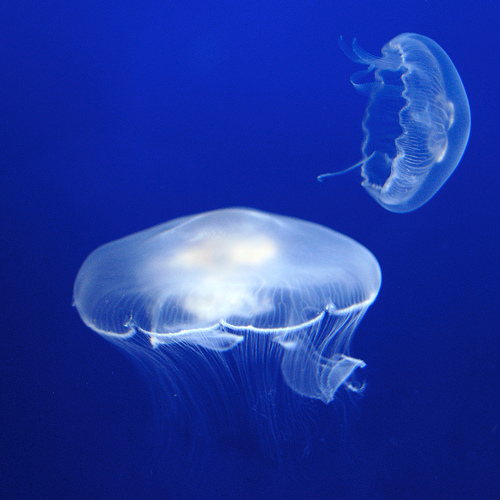

full code distance: 0 /255
 varpatch score: 648.0 


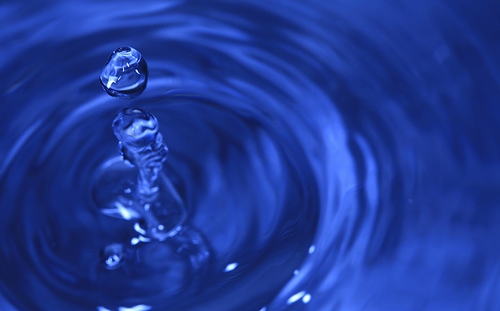

full code distance: 28 /255
 varpatch score: 67.0 


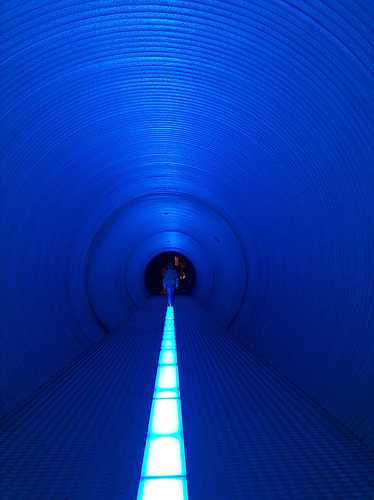

full code distance: 33 /255
 varpatch score: 55.0 


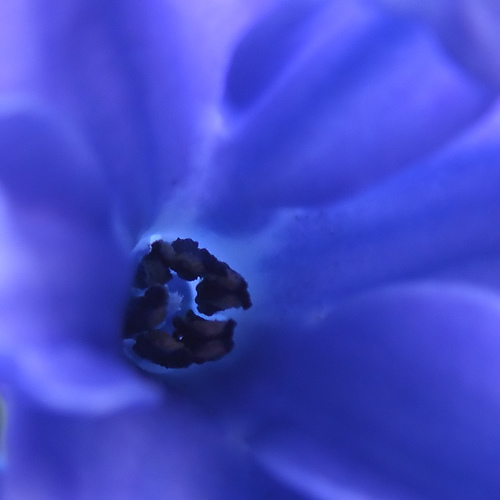

full code distance: 30 /255
 varpatch score: 51.0 


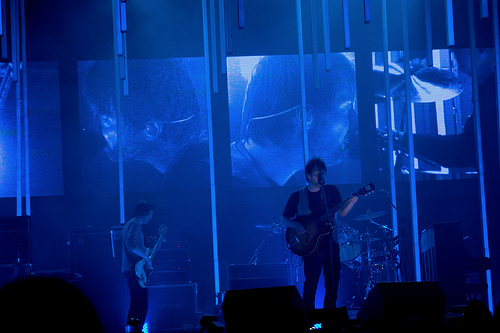

full code distance: 33 /255
 varpatch score: 52.0 


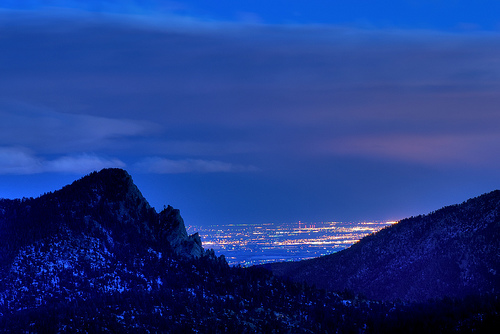

full code distance: 31 /255
 varpatch score: 47.0 


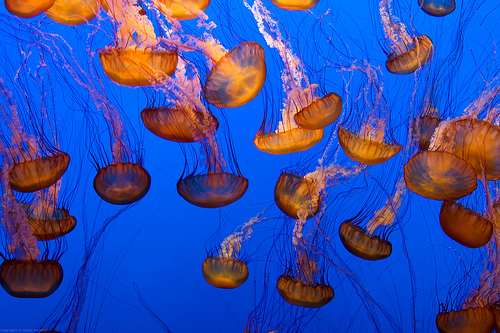

full code distance: 38 /255
 varpatch score: 49.0 


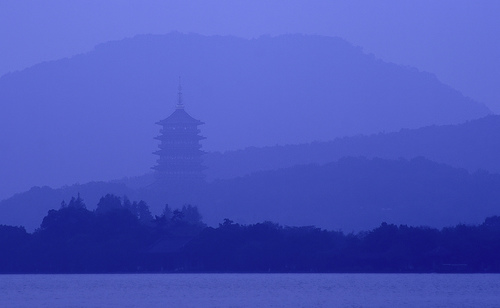

full code distance: 30 /255
 varpatch score: 42.0 


In [26]:
#number of most similar images to display
display_num = 8

for i in range(display_num):
    display(Image(filename = ('./../../data/image_datasets/Flickr_orig/' + images[ranking[i]]), width=200) )
    print('full code distance: {} /255\n varpatch score: {} '.format(dists[ranking[i]], scores[ranking[i]]))



The following code block calculates 28bit varpatch distances for each image-to-image relation and stores them in a hdf5 table, execution may take up to a day

In [ ]:
from ipy_progressbar import ProgressBar
pb = ProgressBar(25000, title='progress', key='outer')
scores = np.zeros((25000,25000))

#28bit distances, may take about a day
with h5py.File('28bit_sim.hdf5', 'a') as f:
    #ds = f.create_dataset('X', shape = (25000,25000) )
    ds = f['X']
    for i in pb:
        scores[:,i] = query_varpatch_codes(i, varpatch_hashing_table, verbose = 0)
    ds[:] = scores